In [337]:
# importing the necessary libraries
import pandas as pd
import numpy as np
import yfinance as yf
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt
import scipy as sc
import requests

In [338]:
class momentum_factors_algo():


    def __init__(self):
        self.etf = 'SPY'
        self.lag =20 # number of lags to adjust for look ahead error
        self.tickers, self.weights = self.get_etf_holdings_ticks() # getting the tickers for the sp500
        self.sp500_df = pd.DataFrame(self.weights, index= self.tickers, columns= ['weights']).sort_index()
        self.spy_etf_df = self.import_securities_data('SPY', 10, 'y')['Adj Close'][-1260 : -1].shift(self.lag).dropna(how= 'all')
        self.selected_time_interval = 252 * 5 # there is 252 trading days per year, multiply times five to get 1,260 days. this will serve as the time interval that we want to look at, we want to look at 5-years of data
        self.etf_holdings_price = self.import_securities_data(self.tickers, 20, 'y')[['Adj Close', 'Volume']] # Importing the stocks from the ticker list and getting the adjusted close prices and volume of each stock
        
        # Storing data related to backtest from the recent 5 years
        self.momentum_factors_df = None
        self.momentum_factors_z_scores = None
        self.long_basket = None
        self.short_basket = None
        self.sp500_lagged_prices = None
        self.long_lagged_prices = None
        self.short_lagged_prices = None
        self.algo_port_prices = None
        self.cumm_rets = None
        self.long_cumm_rets = None
        self.short_cumm_rets = None
        self.algo_port_cumm_rets = None

        # Storing data related to the backtest for 5 years ago
        self.momentum_factors_5yr = None
        self.long_basket_5yr = None
        self.short_basket_5yr = None
        self.long_lagged_prices_5y = None
        self.short_lagged_prices_5y = None
        self.sp500_lagged_prices_5y = None
        self.algo_port_prices_5y = None
        self.cumm_rets_5yr = None
        self.long_cumm_rets_5yr = None
        self.short_cumm_rets_5yr = None
        self.algo_port_cumm_rets_5y = None

        # Storing data related to monthly returns of each basket, sp500, and portfolio of long and short baskets
        self.long_lagged_monthly_rets = None
        self.short_lagged_monthly_rets = None
        self.algo_port_lagged_monthly_rets = None
        self.sp500_monthly_rets = None

        # Storing data related to the backtest for the efficient frontier optimal portfolios
        self.opt_sharpe_port_wghts = None
        self.opt_minvol_port_wghts = None
        self.long_basket_lagged_rets = None
        self.max_sharpe_port_weighted_returns = None
        self.max_sharpe_daily_port_ret = None
        self.max_sharpe_cumm_ret = None
        self.min_vol_port_weighted_returns = None
        self.min_vol_daily_port_ret = None
        self.min_vol_cumm_ret = None
        self.etf_cumm_rets = None

    # Getting the tickers of the sp500 from a publicly listed ETF
    def get_etf_holdings_ticks(self):
        
        # Importing the necessary libraries for getting the tickers
        import requests
        import os
        import xlwings as xw
        import datetime as dt

        # URL path of the folder directory of where I have the ETF holdings files saved
        destination_dir = '/Users/stevenfernandez/Desktop/Python Class/Quant_Fin_Projects_Assignments/Quant_Fin_CCNY-BIZ-BETZ_Spring_2024_SF_MM/berry_cox_price_momentum_port_gen/etf_holdings_data'
        
        # Getting todays date
        today_date = dt.datetime.today().date()

        # Getting todays month out of todays date
        month = today_date.month

        # Getting todays year out of todays date
        year = today_date.year

        # Filename to save the downloaded file, adding the month and year to the file name to keep a trail of the file to check in the future if we have the file based on month and year it was downloaded to the folder directory
        filename = f"state_street_etf_holdings_{month}_{year}.xlsx"
        
        # Combining the destination folder directory with the file name to get the file path
        file_path = os.path.join(destination_dir, filename)

        # Conditional statement ot check if the file exists within our folder directory, if it exists it will open the file and get the tickers. If it doesnt exists it dowloads a new file, saves it on the folder directory, and extracts the tickers from the file
        if not os.path.exists(file_path):
        
            # URL of the Excel file to download from State Street's website
            url = "https://www.ssga.com/us/en/intermediary/etfs/library-content/products/fund-data/etfs/us/holdings-daily-us-en-spy.xlsx"

            # Sending a request to the URL to download the file
            response = requests.get(url)

            # Check if the request was successful (status code 200)
            if response.status_code == 200:

                with open(file_path, "wb") as file:
                    file.write(response.content)
                
                print("File downloaded successfully and saved as:", filename)
            
            else:
                
                print("Failed to download the file. Status code:", response.status_code)
            
            # Open the Excel file
            wb = xw.Book(file_path)

            # Select the worksheet
            sheet = wb.sheets[0]  # getting the first sheet within the Excel file

            # Find the last row of data in column B starting in row 6. this is the same as selecting cell B6 and clicking buttons command shift down, selecting all of the cells from B6 to the last row of data
            last_row = sheet.range('B6').end('down').row

            # Select the range of data in column B from the 6th row to the last row
            tickers = sheet.range(f'B6:B{last_row}').value

            # Select the range of data in column E from the 6th row to the last row
            weights = sheet.range(f'E6:E{last_row}').value

            # Close the workbook
            wb.close()
        
        else:

            # Open the Excel file
            wb = xw.Book(file_path)

            # Select the worksheet
            sheet = wb.sheets[0]  # getting the first sheet within the Excel file

            # Find the last row of data in column B starting in row 6. this is the same as selecting cell B6 and clicking buttons command shift down, selecting all of the cells from B6 to the last row of data
            last_row = sheet.range('B6').end('down').row

            # Select the range of data in column B from the 6th row to the last row
            tickers = sheet.range(f'B6:B{last_row}').value

            # Select the range of data in column E from the 6th row to the last row
            weights = sheet.range(f'E6:E{last_row}').value

            # Close the workbook
            wb.close()

        # some tickers aren't formatted for Yahoo Finance to read them. they are fixed below by looking for them in our list and replacing them with the format that Yahoo Finance reads them
        for i, tick in enumerate(tickers):
            if tick == 'BRK.B':
                tickers[i] = 'BRK-B'
            elif tick == 'BF.B':
                tickers[i] = 'BF-B'
            elif tick == '-': # We take this out of our ticker nad weight list because this is what is put for US Dollars under the tickers column
                del tickers[i]
                del weights[i]

        return tickers, weights
    
    
    # creating a defined function for importing stock data
    def import_securities_data(self, securities_tickers, enter_time_amount, enter_time_type):

        # time delta method function doesnt take the following date time types, it only takes in days. so we convert the respective time types into days by doing some quick math for the user to convert into days
        other_times_types = ['y', 'Y',  'm', 'M', 'w', 'W']
        
        month_type = ['m', 'M']

        week_type = ['w', 'W']

        year_type = ['y', 'Y']

        # if statement that allows us to make a conditional statement to see if the user has inputted any of the time types listed under the other_times_types variable. if so is the case it moves on to the follwing if conditional statements and executes the respective function under the if statement where the conditional value was true
        if enter_time_type in other_times_types:
            
            if enter_time_type in month_type: 
                
                enter_time_amount = 30 * enter_time_amount

            elif enter_time_type in week_type:

                enter_time_amount = 7 * enter_time_amount
            
            elif enter_time_type in year_type:

                enter_time_amount = 365 * enter_time_amount

        
        # create a variable to assign the end date and start dates of the data that we want to dowload, the start date is dynamic and customizable to the user's preference of the data one wants to download
        # credit to John Droescher for this part of the code
        start_date = dt.datetime.today() - pd.Timedelta(enter_time_amount, "d")
        end_date = dt.datetime.today()
        
        # this returns all of the securities related historical data utilizing yahoo finance's API
        return yf.download(start= start_date, end= end_date, tickers= securities_tickers)
    
    
    # Function method to get the corresponding lagged data from our dataframe based on slicing on the number of days that we set back our data for to perform our back-test
    def get_lagged_price_data(self, days_set_back):
        
        # Setting a varaible to get the date that our data should start from
        from_date = days_set_back + self.selected_time_interval

        # Setting a variable to get the to date our date should end
        to_date = days_set_back + 1

        # Slicing our date to get our adjusted close prices starting from_date and ending on to_date and then shifting the date by our number of lag
        lagged_adjprices = self.etf_holdings_price['Adj Close'][-from_date : -to_date].shift(self.lag).dropna(how = 'all')

        return lagged_adjprices


    def calc_momentum_factors(self, days_set_back):
        
        lagged_adjprices = self.get_lagged_price_data(days_set_back)
    
        factors_df = pd.DataFrame(index= self.tickers) # Putting the tickers into a pandas dataframe
        
        # Slope for 52-week trend
        lagged_rolling_mean_price = lagged_adjprices.rolling(window= 52*5).mean().dropna(how='all') # 52 week rolling price average
        lagged_rolling_mean_price['day'] = np.arange(1, len(lagged_rolling_mean_price) + 1) # Counting the number of days within the our sliced data

        for stock in lagged_rolling_mean_price.iloc[:,:len(self.tickers)].columns: # iterating through the columns to obtain the tickers in the ETF
            
            if lagged_rolling_mean_price[stock].notna().all(): # Conditional statement to check if the values are not null within our data set
                
                slope_52_week_trend = np.polyfit(lagged_rolling_mean_price['day'], lagged_rolling_mean_price[stock], 1)[0].round(3) # if so we run a regression to get the 52 week slope trend
            
            else:
                
                slope_52_week_trend = np.nan # if conditional satetment is not true we assing a nan value to that data
            
            factors_df.loc[stock, '52_week_slope'] = slope_52_week_trend # assigning the slope to the repective ticker in our pandas dataframe

        # percent above 260 day low
        percent_above_260 = (lagged_adjprices - lagged_adjprices.rolling(window= 260).min()) / lagged_adjprices.rolling(window= 260).min() # Calculating the percent above 260 days low
        factors_df['percent_above_260_day_low'] = percent_above_260.dropna(how= 'all').mean().round(3) # Assigning the values to each of its respective ticker in the pandas datafrane

        # calculate 4/52 price oscillator. Formula: (rolling 4 week mean - rolling 52 week mean / rolling 52 week mean * 100)
        price_oscillator = (lagged_adjprices.rolling(window=4*5).mean() - lagged_adjprices.rolling(window=52*5).mean()) / lagged_adjprices.rolling(window=52*5).mean()
        factors_df['4/52week_price_oscillator'] = price_oscillator.dropna(how = 'all').mean().round(3) # Assigning the values to each of its respective ticker in the pandas datafrane

        # Calculating 39 week return and assigning the values to each of its respective ticker in the pandas datafrane
        factors_df['returns_39week_period'] = lagged_adjprices.pct_change(periods= 39 * 5).mean().dropna(how = 'all').round(3)

        # Caculating 51 week volume price trend
        volume_lag_rollmean = self.etf_holdings_price['Volume'].shift(self.lag).dropna(how= 'all').rolling(51*5).mean().dropna(how= 'all') # First lagging our volume data, second getting 51 week rolling average volume
        vpt_51wkly = (volume_lag_rollmean * lagged_adjprices.pct_change(periods= 51*5)).cumsum().dropna(how= 'all').round(3) # Getting the product of the returns and volume. Then getting the cumulative sum overtime of the volume price trend

        factors_df['volume_price_trend'] = vpt_51wkly.mean().round(3) # Assigning the values to each of its respective ticker in the pandas datafrane
        
        # Returning our data frame storing all of the factor calculated data
        return factors_df
    

    def calculate_z_scores(self, x): # where x is equal to the momentum factors
       
        z_scores = (x - x.mean()) / x.std() # standard z score formula. Normalizing our momentum factors
        z_scores = z_scores.sum(axis=1) # summing the z-scores of each factor to get the total z-score per asset
        # The z-score is the number of standard deviations away from the mean a data point is.
        momentum_factors_z_scores = z_scores.sort_values(ascending=False)
        
        return momentum_factors_z_scores


    # function to calculate our cumulative returns
    def calculate_cumulative_returns(self, dataf): 
        
        # Calculating the returns of the provided dataframe
        returns = dataf.pct_change()

        # Getting the cumulative return over time for every security and then getting the average returns of each day for the portfolio. This is done by getting the cumulative product over time since returns are compounded overtime and then getting the daily average returns by averaging out all the returns for the basket for the day.
        cumulative_returns = (1 + returns).cumprod().mean(axis=1)*100

        return cumulative_returns


    def calc_backtest(self):
        
        # Calculating momentum factors, calculating z-scores, getting long and short baskets from z-scores, getting lagged pricing data for each basket based on data from the recent 5 years and then calculating the cumalative returns to plot the back-test
        self.momentum_factors_df = self.calc_momentum_factors(0)
        self.long_basket = self.calculate_z_scores(self.momentum_factors_df)[:10] # selects the top 10 z-scores
        self.short_basket = self.calculate_z_scores(self.momentum_factors_df)[-10:] # selects the bottom 10 z-scores
        self.sp500_lagged_prices = self.get_lagged_price_data(0) # Getting lagged prices for our sp500
        self.long_lagged_prices = self.sp500_lagged_prices[self.long_basket.index] # slicing based on the ticker that we have on our calculated long bascket
        self.short_lagged_prices = self.sp500_lagged_prices[self.short_basket.index] # slicing based on the ticker that we have on our calculated short bascket
        self.algo_port_prices = pd.merge(self.short_lagged_prices, self.long_lagged_prices, left_index= True, right_index= True, how= 'inner') # merging our short and long basket price data to get our portfolio price data
        self.cumm_rets = self.calculate_cumulative_returns(self.sp500_lagged_prices) # Getting cumulative returns for the sp500
        self.long_cumm_rets = self.calculate_cumulative_returns(self.long_lagged_prices) # Getting cumulative returns for the long basket
        self.short_cumm_rets = self.calculate_cumulative_returns(self.short_lagged_prices) # Getting cumulative returns for our short basket
        self.algo_port_cumm_rets = self.calculate_cumulative_returns(self.algo_port_prices) # Getting cumulative returns for the portfolio of long and short baskets

        # Calculating momentum factors, calculating z-scores, getting long and short baskets from z-scores, getting lagged pricing data for each basket based on data from five years ago and then calculating the cumalitive returns to plot hte back-test
        self.momentum_factors_5yr = self.calc_momentum_factors(252 * 5)
        self.long_basket_5yr = self.calculate_z_scores(self.momentum_factors_5yr)[:10]
        self.short_basket_5yr = self.calculate_z_scores(self.momentum_factors_5yr)[-10:]
        self.long_lagged_prices_5y = self.get_lagged_price_data(252 * 5)[self.long_basket_5yr.index]
        self.short_lagged_prices_5y = self.get_lagged_price_data(252 * 5)[self.short_basket_5yr.index]
        self.sp500_lagged_prices_5y = self.get_lagged_price_data(252 * 5)
        self.algo_port_prices_5y = pd.merge(self.short_lagged_prices_5y, self.long_lagged_prices_5y, left_index= True, right_index= True, how= 'inner')
        self.cumm_rets_5yr = self.calculate_cumulative_returns(self.sp500_lagged_prices_5y) # Getting cumulative returns for the sp500 based on data from 5 years ago
        self.long_cumm_rets_5yr = self.calculate_cumulative_returns(self.long_lagged_prices_5y) # Getting cumulative returns for the short basket based on data from 5 years ago
        self.short_cumm_rets_5yr = self.calculate_cumulative_returns(self.short_lagged_prices_5y) # Getting cumulative returns for the long basket based on data from 5 years ago
        self.algo_port_cumm_rets_5y = self.calculate_cumulative_returns(self.algo_port_prices_5y) # Getting cumulative returns for the protfolio of long and short basket based on data from 5 years ago

        # Calculating the monthly returns for hte short and long baskets, portfolio and the sp500
        self.long_lagged_monthly_rets = self.long_lagged_prices.pct_change(20).mean(axis= 1).dropna(how= 'all') # Calculating the monthly mean return of our long basket portfolio
        self.short_lagged_monthly_rets = self.short_lagged_prices.pct_change(20).mean(axis= 1).dropna(how= 'all') # Calculating the monthly mean return of our short basket portfolio
        self.algo_port_lagged_monthly_rets = self.algo_port_prices.pct_change(20).mean(axis= 1).dropna(how= 'all') # Calculating the monthly mean return of our portfolio of long and short basket
        self.sp500_monthly_rets = self.sp500_lagged_prices.pct_change(20).mean(axis= 1).dropna(how= 'all') # Calculating the monthly mean return of the sp500

        return
    

    def plot_short_long_backtest_from_recent5yrs(self):
        
        # Plot the line chart
        plt.style.use('fivethirtyeight')
        plt.figure(figsize=(11,4))
        self.long_cumm_rets.plot(label='Long Basket', lw=2) # lw is line width
        self.cumm_rets.plot(label='SP500', lw =2)
        self.short_cumm_rets.plot(label='Short Basket', lw=2)

        plt.legend()
        plt.title('Cumulative Returns')
        plt.xlabel('Year')
        plt.ylabel('Cumulative Returns (%)')
        plt.show()
        
        return
    
    
    def plot_portfolio_backtest_from_recent5yrs(self):
        
        # Plot the line chart
        plt.style.use('fivethirtyeight')
        plt.figure(figsize=(11,4))
        self.cumm_rets.plot(label='SP500', lw =2)
        self.algo_port_cumm_rets.plot(label='Portfolio', lw=2)

        plt.legend()
        plt.title('Portfolio vs ETF Cumulative Returns')
        plt.xlabel('Year')
        plt.ylabel('Cumulative Returns (%)')
        plt.show()

        return
    
    
    def plot_short_long_backtest_from_5yrsback(self):
        
        # Plot the line chart
        plt.style.use('fivethirtyeight')
        plt.figure(figsize=(11,4))
        self.long_cumm_rets_5yr.plot(label='Long Basket', lw=2)
        self.cumm_rets_5yr.plot(label='SP500', lw =2)
        self.short_cumm_rets_5yr.plot(label='Short Basket', lw=2)

        plt.legend()
        plt.title('Cumulative Returns (Back-Tested Five-Years Ago)')
        plt.xlabel('Year')
        plt.ylabel('Cumulative Returns (%)')
        plt.show()

        return
    

    def plot_portfolio_backtest_from_5yrsback(self):
        
        # Plot the line chart
        plt.style.use('fivethirtyeight')
        plt.figure(figsize=(11,4))
        self.cumm_rets_5yr.plot(label='SP500', lw =2)
        self.algo_port_cumm_rets_5y.plot(label='Portfolio', lw=2)

        plt.legend()
        plt.title('Portfolio vs. ETF Cumulative Returns (Back-Tested Five-Years Ago)')
        plt.xlabel('Year')
        plt.ylabel('Cumulative Returns (%)')
        plt.show()
        
        return


    def plot_long_basket_monthly_returns_recent5yrs(self):
        
        # Plot the bar chart
        plt.style.use('fivethirtyeight')
        plt.figure(figsize=(11,4))
        plt.bar(self.long_lagged_monthly_rets.index, self.long_lagged_monthly_rets.values, color=['r' if m < 0 else 'g' for m in self.long_lagged_monthly_rets], width=1.3)

        # Customize the plot
        plt.tick_params(axis='both', labelsize=9)
        plt.xticks(rotation=90)
        plt.ylim(-0.5, 0.5) 
        plt.ylabel('Return', labelpad=9)
        plt.xlabel('Date', labelpad=5)
        plt.title('Long Basket Monthly Returns', pad=9)
        plt.show()

        return
    

    def plot_short_basket_monthly_returns_recent5yrs(self):
        
        # Plot the bar chart
        plt.style.use('fivethirtyeight')
        plt.figure(figsize=(11,4))
        plt.bar(self.short_lagged_monthly_rets.index, self.short_lagged_monthly_rets.values, color=['r' if m < 0 else 'g' for m in self.short_lagged_monthly_rets], width=1.3)

        # Customize the plot
        plt.tick_params(axis='both', labelsize=9)
        plt.xticks(rotation=90)
        plt.ylim(-0.5, 0.5) 
        plt.ylabel('Return', labelpad=9)
        plt.xlabel('Date', labelpad=5)
        plt.title('Short Basket Monthly Returns', pad=9)
        plt.show()
        
        return
    

    def plot_portfolio_basket_monthly_returns_recent5yrs(self):
        
        # Plot the bar chart
        plt.style.use('fivethirtyeight')
        plt.figure(figsize=(11,4))
        plt.bar(self.algo_port_lagged_monthly_rets.index, self.algo_port_lagged_monthly_rets.values, color=['r' if m < 0 else 'g' for m in self.algo_port_lagged_monthly_rets], width=1.3)

        # Customize the plot
        plt.tick_params(axis='both', labelsize=9)
        plt.xticks(rotation=90)
        plt.ylim(-0.5, 0.5) 
        plt.ylabel('Return', labelpad=9)
        plt.xlabel('Date', labelpad=5)
        plt.title('Portfolio Monthly Returns (Long + Short Basket)', pad=9)
        plt.show()
        
        return


    def plot_sp500_monthly_returns_recent5yrs(self):
        
        # Plot the bar chart
        plt.style.use('fivethirtyeight')
        plt.figure(figsize=(11,4))
        plt.bar(self.sp500_monthly_rets.index, self.sp500_monthly_rets.values, color=['r' if m < 0 else 'g' for m in self.sp500_monthly_rets], width=1.3)

        # Customize the plot
        plt.tick_params(axis='both', labelsize=9)
        plt.xticks(rotation=90)
        plt.ylim(-0.5, 0.5) 
        plt.ylabel('Return', labelpad=9)
        plt.xlabel('Date', labelpad=5)
        plt.title('SP500 Monthly Returns', pad=9)
        plt.show()

        return
    

    def calc_eff_frontier(self):
        
        # Run the efficient frontier and montecarlo python file
        %run efficient_frontier_berry_cox.py

        efficient_frontier = eff_frontier(self.long_lagged_prices) # Accesing the class defined within the file and importing the data for our long basket

        efficient_frontier.montecarlo_sim() # Monte Carlo simulation

        efficient_frontier.calculatedresults() # calucalting our efficient frontier results

        self.opt_sharpe_port_wghts = efficient_frontier.maxsharpe_port_weights.values / 100
        self.opt_minvol_port_wghts = efficient_frontier.minvol_port_weights.values / 100

        return efficient_frontier
    
    def calc_opt_eff_front_backtest(self):
        # Partial credit: https://www.codingfinance.com/post/2018-04-10-cumulative-portfolio-returns-py/
        
        long_sharpe_basket_lagged_rets = self.long_lagged_prices.pct_change().dropna(how= 'all')

        for value, stock in zip(self.opt_sharpe_port_wghts, long_sharpe_basket_lagged_rets.columns):
            if value == 0:
                long_sharpe_basket_lagged_rets.drop(columns=stock, inplace=True)

        max_sharpe_port_wghts = self.opt_sharpe_port_wghts[self.opt_sharpe_port_wghts != 0]
        
        self.max_sharpe_port_weighted_returns = (max_sharpe_port_wghts * long_sharpe_basket_lagged_rets)
        self.max_sharpe_cumm_ret = (1 + self.max_sharpe_port_weighted_returns).cumprod().mean(axis= 1) * 100


        long_minvol_basket_lagged_rets = self.long_lagged_prices.pct_change().dropna(how= 'all')
        
        for value, stock in zip(self.opt_minvol_port_wghts, long_minvol_basket_lagged_rets.columns):
            if value == 0:
                long_minvol_basket_lagged_rets.drop(columns=stock, inplace=True)

        min_vol_port_wghts = self.opt_minvol_port_wghts[self.opt_minvol_port_wghts != 0]

        self.min_vol_port_weighted_returns = (min_vol_port_wghts * long_minvol_basket_lagged_rets)
        self.min_vol_cumm_ret = (1 + self.min_vol_port_weighted_returns).cumprod().mean(axis= 1) * 100


        etf_rets = self.spy_etf_df.pct_change().dropna(how= 'all')
        self.etf_cumm_rets = (1+ etf_rets).cumprod() * 100

        return
    
    def plot_opt_ports_backtest(self):
        
        # Plot the line chart
        plt.style.use('fivethirtyeight')
        plt.figure(figsize=(11,4))
        self.etf_cumm_rets.plot(label='SP500', lw =2)
        self.max_sharpe_cumm_ret.plot(label='Max Sharpe Port', lw=2)
        self.min_vol_cumm_ret.plot(label='Minimum Volatility Port', lw=2)

        plt.legend()
        plt.title('Optimal Portfolios vs sp500 Cumulative Returns')
        plt.xlabel('Year')
        plt.ylabel('Cumulative Returns (%)')
        plt.show()
        
        return

In [339]:
mfa = momentum_factors_algo()

mfa.calc_backtest()

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  503 of 503 completed
/var/folders/sm/0p9xlw3950bcl1jg6rphjx540000gn/T/ipykernel_22513/3646516536.py:240: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Call ffill before calling pct_change to retain current behavior and silence this warning.
  factors_df['returns_39week_period'] = lagged_adjprices.pct_change(periods= 39 * 5).mean().dropna(how = 'all').round(3)
/var/folders/sm/0p9xlw3950bcl1jg6rphjx540000gn/T/ipykernel_22513/3646516536.py:244: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Call ffill before calling pct_change to retain current behavior and silence this warning.
  vpt_51wkly = (volume_lag_rollmean * lagged_adjprices.pct_change(periods= 51*5)).cumsum().dropna(how= 'all').round(3) # Getting the product 

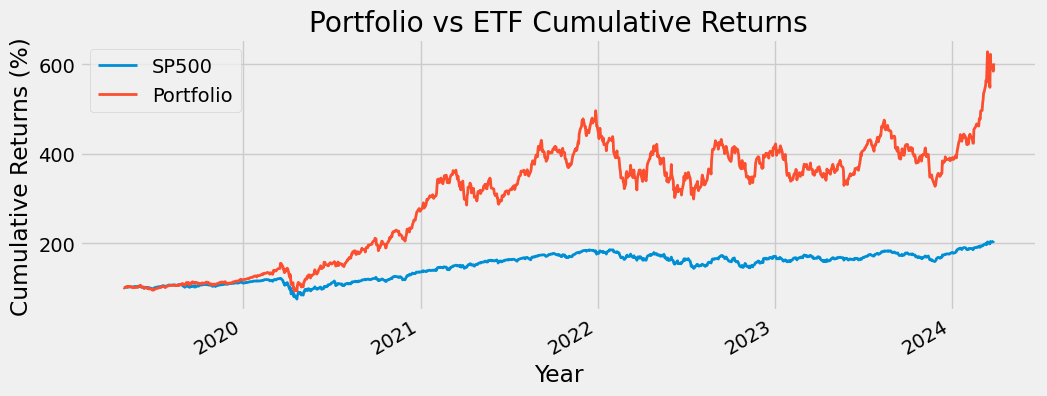

In [340]:
mfa.plot_portfolio_backtest_from_recent5yrs()

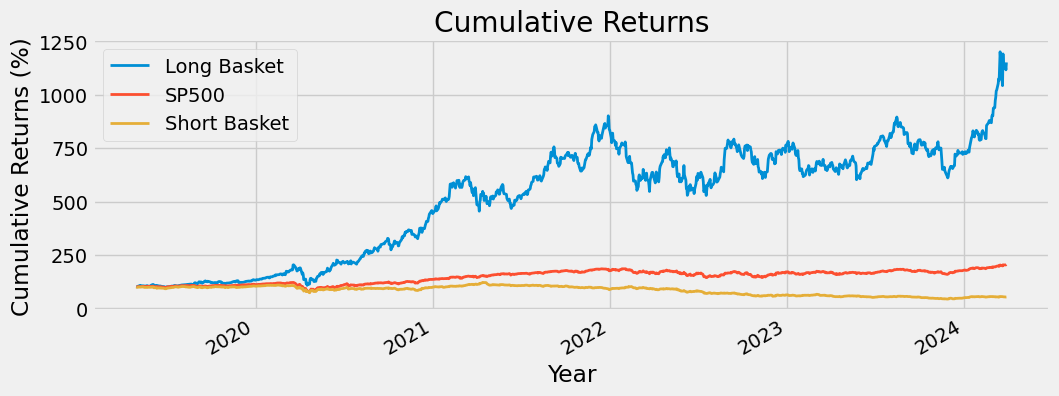

In [341]:
mfa.plot_short_long_backtest_from_recent5yrs()

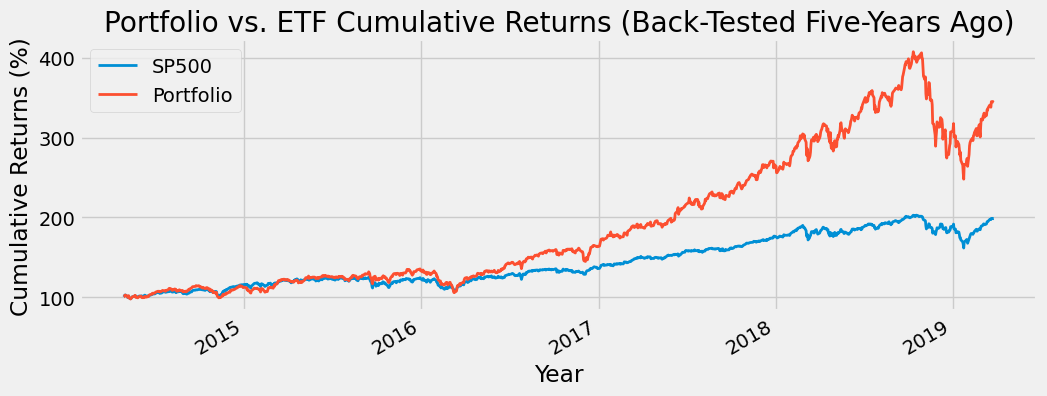

In [342]:
mfa.plot_portfolio_backtest_from_5yrsback()

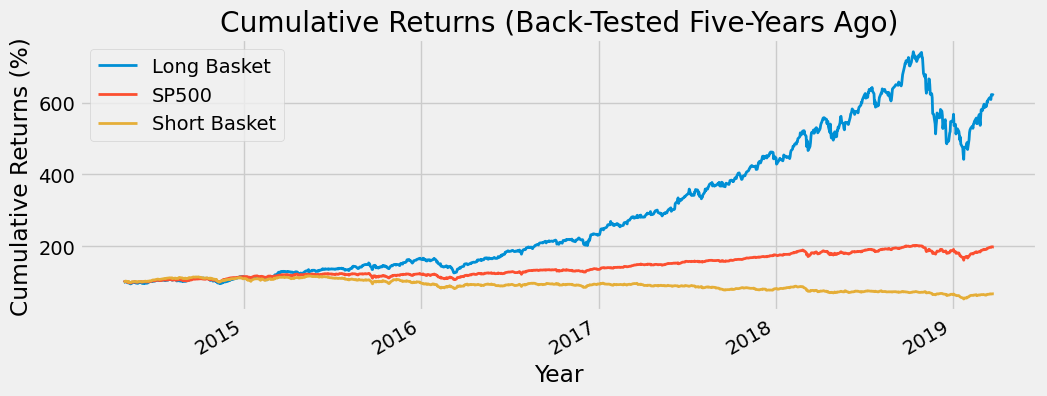

In [343]:
mfa.plot_short_long_backtest_from_5yrsback()

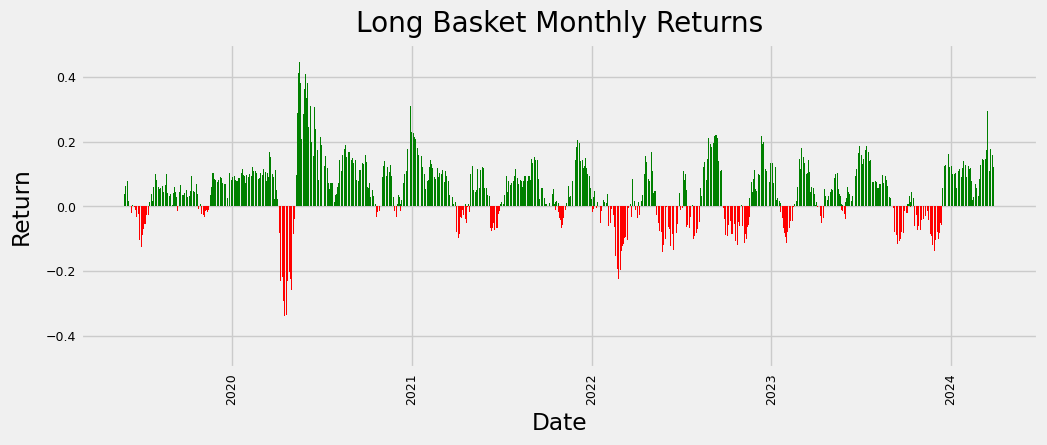

In [344]:
mfa.plot_long_basket_monthly_returns_recent5yrs()

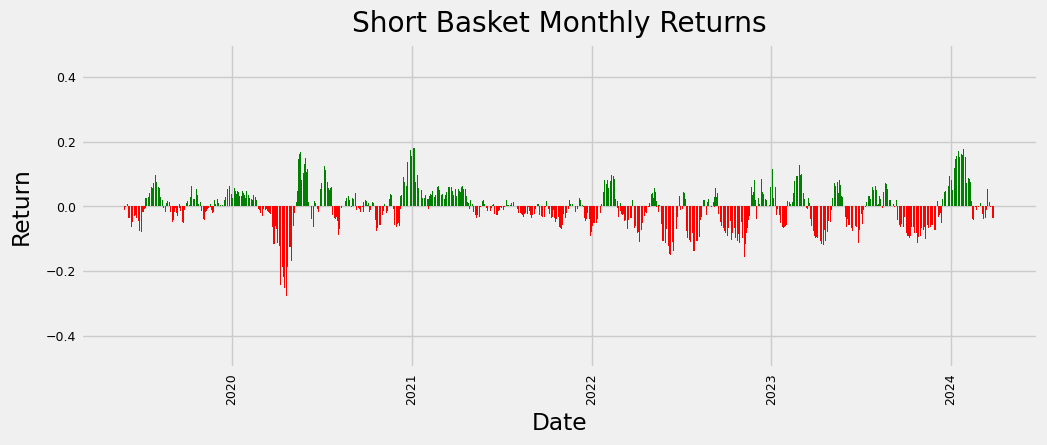

In [345]:
mfa.plot_short_basket_monthly_returns_recent5yrs()

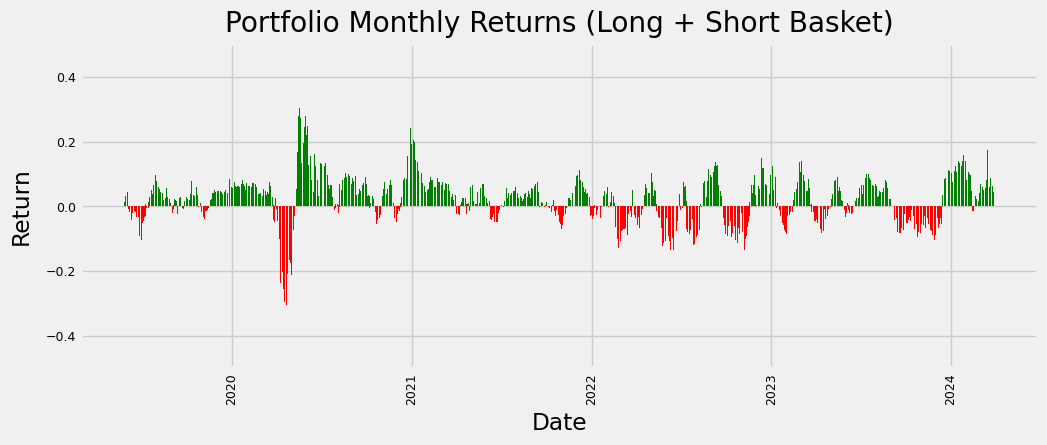

In [346]:
mfa.plot_portfolio_basket_monthly_returns_recent5yrs()

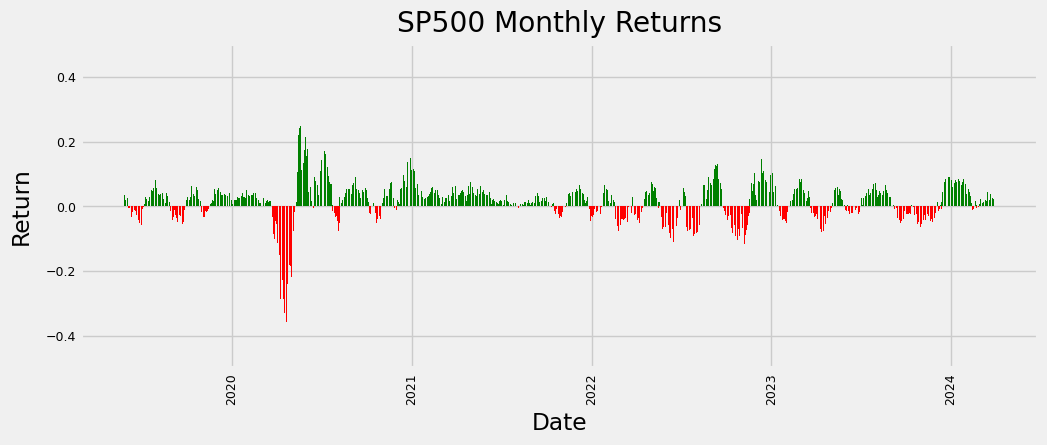

In [347]:
mfa.plot_sp500_monthly_returns_recent5yrs()

In [348]:
efficient_frontier = mfa.calc_eff_frontier()

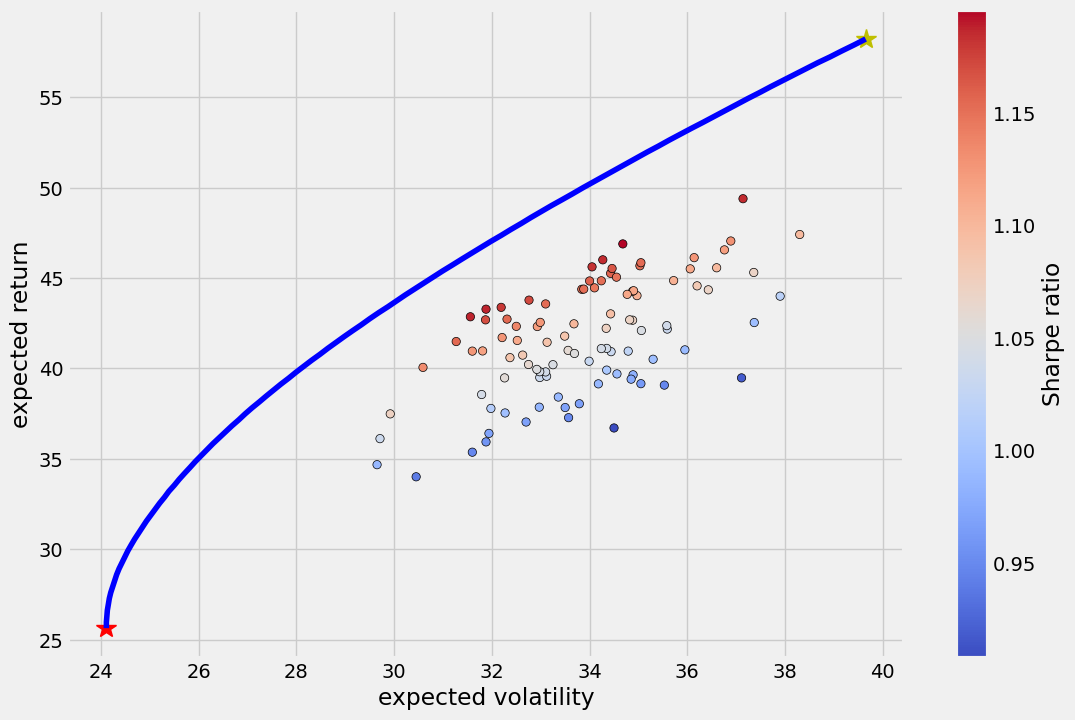

In [349]:
efficient_frontier.plot_efficientfront()

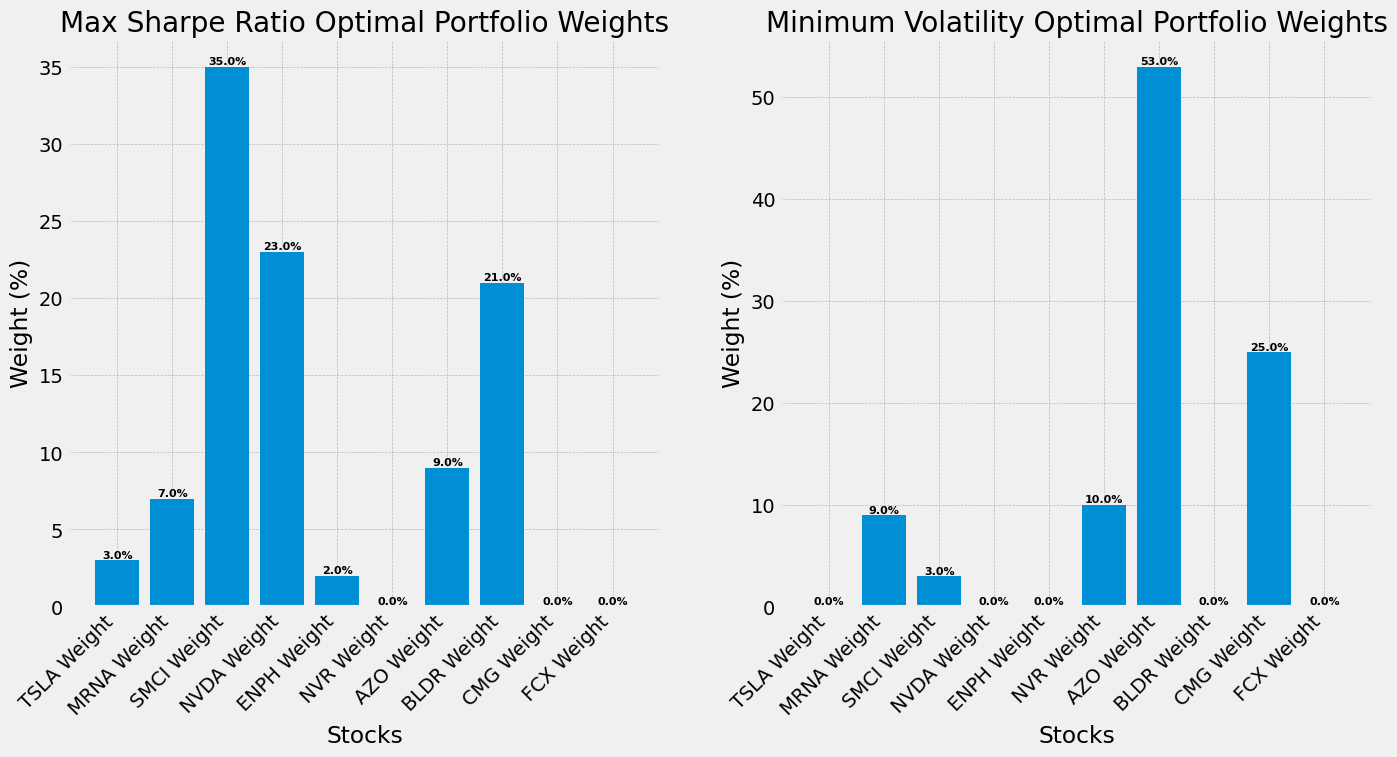

In [350]:
efficient_frontier.plot_optport_weights()

/Users/stevenfernandez/Desktop/Python Class/Quant_Fin_Projects_Assignments/Quant_Fin_CCNY-BIZ-BETZ_Spring_2024_SF_MM/berry_cox_price_momentum_port_gen/efficient_frontier_berry_cox.py:453: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_xticklabels(['Max Sharpe Ratio Portfolio', 'Minimum Volatility Portfolio'])
/Users/stevenfernandez/Desktop/Python Class/Quant_Fin_Projects_Assignments/Quant_Fin_CCNY-BIZ-BETZ_Spring_2024_SF_MM/berry_cox_price_momentum_port_gen/efficient_frontier_berry_cox.py:469: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_xticklabels(['Max Sharpe Ratio Portfolio', 'Minimum Volatility Portfolio'])


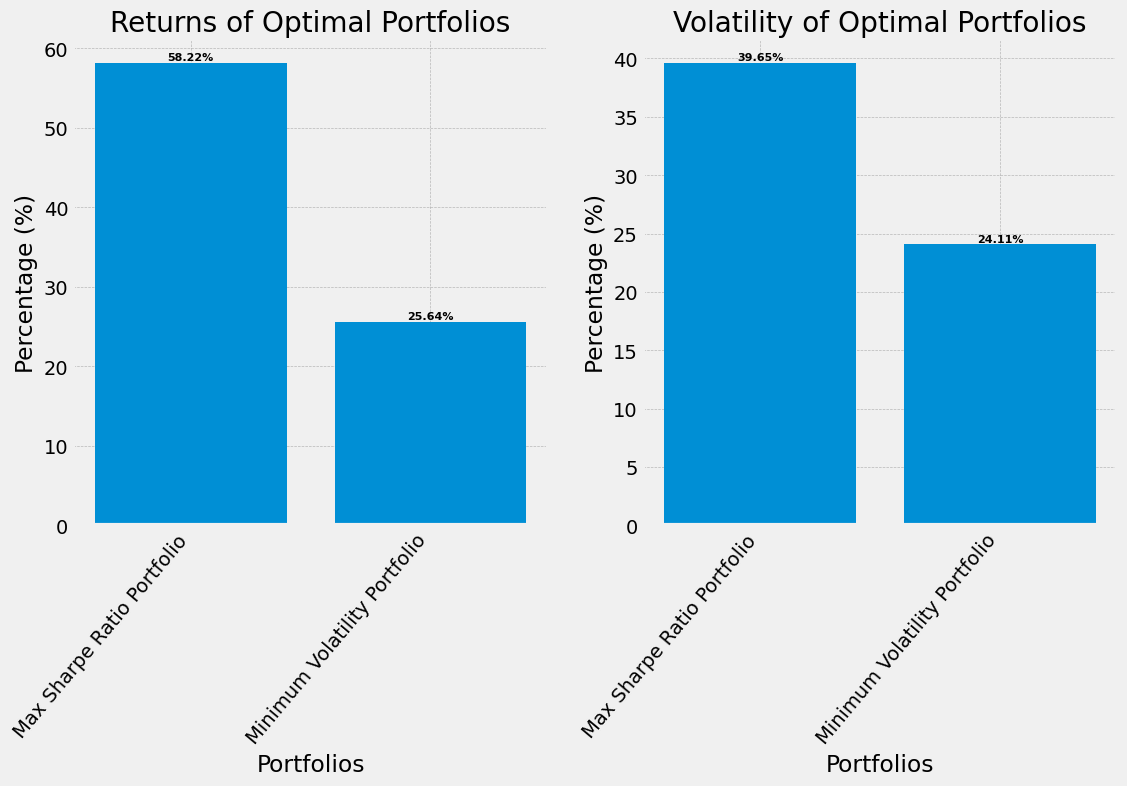

In [351]:
efficient_frontier.plot_rets_vol_optports()

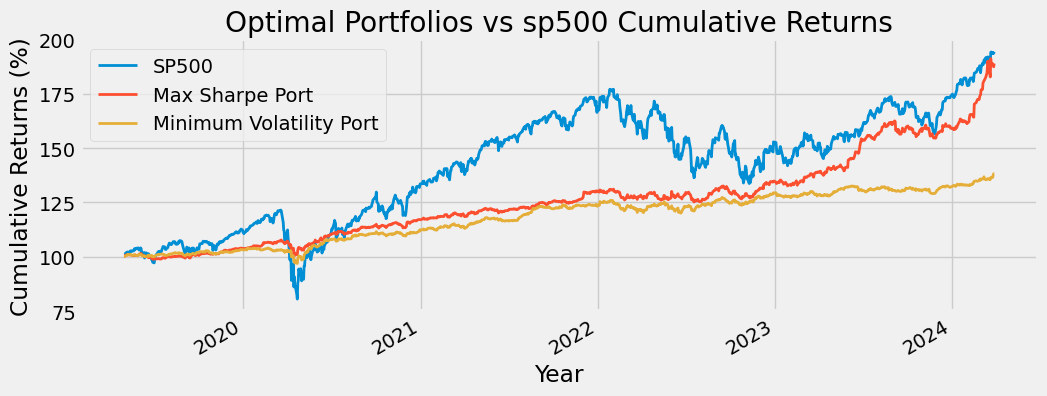

In [352]:
mfa.calc_opt_eff_front_backtest()

mfa.plot_opt_ports_backtest()

# Working Space 

In [353]:
(1 + mfa.max_sharpe_port_weighted_returns).cumprod().mean(axis= 1) * 100

Date
2019-04-30    100.351447
2019-05-01    100.293190
2019-05-02    100.550394
2019-05-03    100.703805
2019-05-06    100.912606
                 ...    
2024-03-22    188.337645
2024-03-25    188.847752
2024-03-26    188.365898
2024-03-27    187.400442
2024-03-28    188.897413
Length: 1238, dtype: float64

In [354]:
for i, value in enumerate(mfa.opt_sharpe_port_wghts):
    if value == 0:
        print(i, mfa.long_lagged_prices.columns[i])

5 NVR
8 CMG
9 FCX


In [355]:
mfa.max_sharpe_port_weighted_returns

Ticker,TSLA,MRNA,SMCI,NVDA,ENPH,AZO,BLDR
Date,,,,,,,
2019-04-30,0.000999,0.000826,0.012754,0.003484,0.000065,0.000491,0.005982
2019-05-01,-0.000342,-0.003026,0.000799,0.000909,0.000194,0.001072,-0.003673
2019-05-02,0.000622,0.005792,0.001116,0.007063,0.000727,0.000307,0.002337
2019-05-03,-0.002470,0.005743,-0.000159,-0.000439,-0.000351,-0.000417,0.008782
2019-05-06,0.000804,0.008735,0.000318,0.003286,0.000672,0.000677,0.000000
...,...,...,...,...,...,...,...
2024-03-22,-0.000827,-0.002098,-0.041443,0.000817,-0.000851,-0.000079,0.000334
2024-03-25,0.001161,-0.001771,0.006646,0.000802,0.000279,0.000461,0.001970
2024-03-26,0.000050,0.001623,-0.010077,-0.001137,0.000212,0.005995,0.002999


In [356]:
mfa.opt_sharpe_port_wghts[mfa.opt_sharpe_port_wghts != 0]

array([0.03, 0.07, 0.35, 0.23, 0.02, 0.09, 0.21])

In [357]:
mfa.opt_minvol_port_wghts[mfa.opt_minvol_port_wghts != 0]

array([0.09, 0.03, 0.1 , 0.53, 0.25])

In [358]:
efficient_frontier.montc_portfolio_data[efficient_frontier.montc_portfolio_data['sharpe'] == efficient_frontier.montc_portfolio_data['sharpe'].max()].iloc[:,3:].values / 100
(1+(mfa.long_lagged_prices.pct_change().dropna(how= 'all')*(efficient_frontier.montc_portfolio_data[efficient_frontier.montc_portfolio_data['sharpe'] == efficient_frontier.montc_portfolio_data['sharpe'].max()].iloc[:,3:].values / 100))).cumprod().mean(axis= 1) * 100

Date
2019-04-30    100.190443
2019-05-01    100.114565
2019-05-02    100.365245
2019-05-03    100.468281
2019-05-06    100.785360
                 ...    
2024-03-22    141.187970
2024-03-25    141.332263
2024-03-26    141.457089
2024-03-27    141.309677
2024-03-28    141.625915
Length: 1238, dtype: float64

In [359]:
efficient_frontier.montc_portfolio_data[efficient_frontier.montc_portfolio_data['sharpe'] == efficient_frontier.montc_portfolio_data['sharpe'].max()].iloc[:,3:].values / 100

array([[0.1 , 0.18, 0.21, 0.02, 0.12, 0.02, 0.19, 0.15, 0.01, 0.  ]])

In [360]:
(mfa.sp500_df.T.values/100).sum()

0.9996791300000001

In [361]:
(1 +((mfa.sp500_df.T.values/100) * mfa.sp500_lagged_prices.pct_change().dropna(how= 'all'))).cumprod().mean(axis= 1) * 100

Date
2019-04-30    100.002461
2019-05-01    100.002700
2019-05-02    100.003749
2019-05-03    100.003740
2019-05-06    100.004852
                 ...    
2024-03-22    100.246964
2024-03-25    100.246221
2024-03-26    100.246587
2024-03-27    100.246232
2024-03-28    100.247456
Length: 1238, dtype: float64

In [362]:
mfa.sp500_lagged_prices.pct_change().dropna(how= 'all').columns

Index(['A', 'AAL', 'AAPL', 'ABBV', 'ABNB', 'ABT', 'ACGL', 'ACN', 'ADBE', 'ADI',
       ...
       'WY', 'WYNN', 'XEL', 'XOM', 'XRAY', 'XYL', 'YUM', 'ZBH', 'ZBRA', 'ZTS'],
      dtype='object', name='Ticker', length=503)

In [363]:
(1 + mfa.import_securities_data('SPY', 10, 'y')['Adj Close'][-1260 : -1].shift(mfa.lag).dropna(how= 'all').pct_change().dropna(how= 'all')).cumprod() * 100

[*********************100%%**********************]  1 of 1 completed


Date
2019-04-30    101.185916
2019-05-01    101.235522
2019-05-02    101.394806
2019-05-03    101.663862
2019-05-06    102.155928
                 ...    
2024-03-22    194.228301
2024-03-25    193.516936
2024-03-26    193.876447
2024-03-27    193.620211
2024-03-28    194.316261
Name: Adj Close, Length: 1238, dtype: float64